In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
''' Link to explain how to download Datasets from kaggle https://www.kaggle.com/general/74235'''

!pip install -q kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d scribbless/another-anime-face-dataset

100% 1.43G/1.44G [00:22<00:00, 92.3MB/s]
100% 1.44G/1.44G [00:22<00:00, 68.7MB/s]


In [ ]:
!unzip /content/another-anime-face-dataset.zip

In [ ]:
!pip install tensorflow-gpu
!pip install keras
!pip install python-opencv
!pip install matplotlib
!pip install numpy

Download the dataset from here:
https://drive.google.com/file/d/1lUmzcMUFJSF60DFMK5yKQClGqg9v8fcP/view?usp=sharing
And extract it into your working directory

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

In [9]:
image_dir = "/content/animefaces256cleaner/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['/content/animefaces256cleaner/29052853_result.jpg',
 '/content/animefaces256cleaner/97511900_result.jpg']

In [10]:
# preprocess
image_size = 64

def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 3,))
    return image

In [11]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [12]:
len(training_dataset)

721

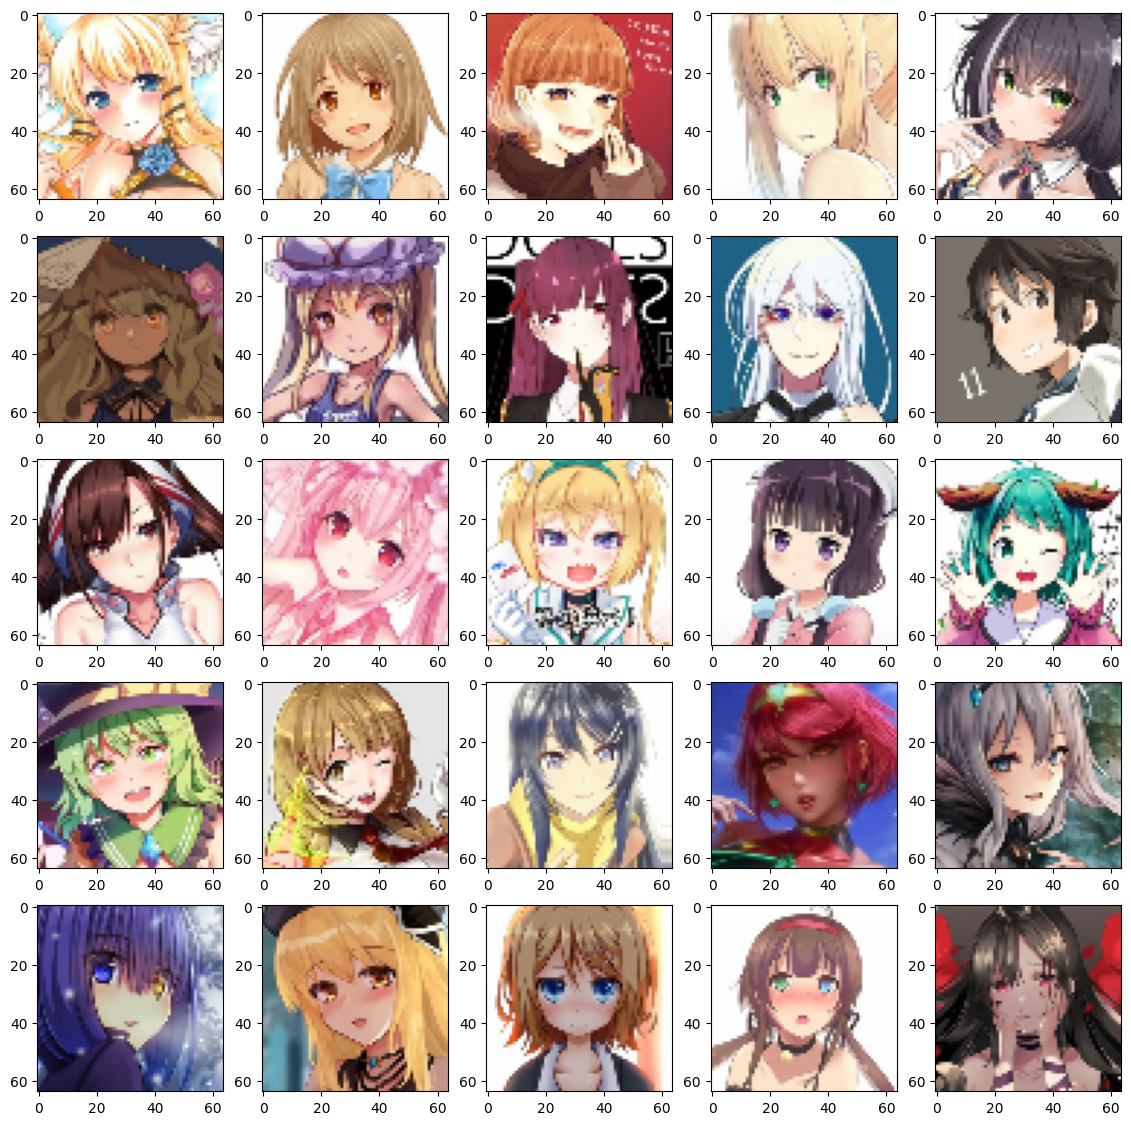

In [13]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [14]:
# build the model

latent_dim = 512

In [16]:
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers import LeakyReLU
from keras.activations import selu
from keras.layers import Multiply, Add
from keras.optimizers import Adam

from keras import backend as K


In [17]:
K.clear_session()

In [18]:
encoder_input = Input(shape = (64,64,3))

x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input)
x = BatchNormalization()(x)

filter_size = [64,128,256,512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# sampling layer
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps])

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           2432      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           51264     ['batch_normalization[0]

In [19]:
# build the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         3277056   
 anspose)                                                        
                                                                 
 batch_normalization_7 (Bat  (None, 8, 8, 256)         1

In [20]:
# make loss function
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [21]:
# conbine encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 512),                1380268   ['input_1[0][0]']             
                              (None, 512),                8                                       
                              (None, 512)]                                                        
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 3)            1328302   ['encoder[0][2]']             
                                                          3                                     

In [22]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = "output/"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [23]:

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

1/1 [==============================] - 3s 3s/step


In [ ]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 100

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])

            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())

            kl = sum(model.losses)
            kl_losses.append(kl.numpy())

            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

1/1 [==============================] - 0s 18ms/step
Epoch:  1


1/1 [==============================] - 0s 25ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.098319374 - KL loss: 0.0011544779
Epoch: 1 - Step: 1 - MSE loss: 0.093209594 - KL loss: 0.0008570933
Epoch: 1 - Step: 2 - MSE loss: 0.098888695 - KL loss: 0.00068171596
Epoch: 1 - Step: 3 - MSE loss: 0.09916554 - KL loss: 0.0005107536
Epoch: 1 - Step: 4 - MSE loss: 0.094147265 - KL loss: 0.00039102777
Epoch: 1 - Step: 5 - MSE loss: 0.098068304 - KL loss: 0.00031750917
Epoch: 1 - Step: 6 - MSE loss: 0.096091814 - KL loss: 0.00026054622
Epoch: 1 - Step: 7 - MSE loss: 0.10128167 - KL loss: 0.0002223529
Epoch: 1 - Step: 8 - MSE loss: 0.09772569 - KL loss: 0.00018550223
Epoch: 1 - Step: 9 - MSE loss: 0.09542935 - KL loss: 0.00016027932
1/1 [==============================] - 0s 17ms/step
Epoch: 1 - Step: 10 - MSE loss: 0.0980739 - KL loss: 0.00014789974
Epoch: 1 - Step: 11 - MSE loss: 0.100307144 - KL loss: 0.00014446976
Epoch: 1 - Step: 12 - MSE loss: 0.09267706 - KL loss: 0.00014467079
Epoch: 1 - Step: 13 

In [ ]:
# visualize output

import cv2
output_dir = "output/"
files = os.listdir(output_dir)

for file in files:
    image = cv2.imread(output_dir + file)
    cv2.imshow("Output", image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break